# Goal: map RGN images -> Thermal images
Idea:
1. Select corresponding points - Use feature detection algo like SIFT, SURF, or ORB (opencv)
3. Represent in homogenous coordinates
4. Setup system of equations
5. Solve for affine transformation matrix
6. Validation


## Data loading

In [85]:
from PIL import Image, ImageChops, ImageDraw, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
DIR_PATH = "/Users/helen/Desktop/GS_urop/Code/"
test_im = "20230919_143722"
# test_im = "20230919_140227"

rgn_path = f"{DIR_PATH}/data/datasets/Sep19Boston_greenscan/images/{test_im}_RGN.jpg"
thermal_path = f"{DIR_PATH}/data/datasets/Sep19Boston_greenscan/images/{test_im}_Thermal.jpg"

In [3]:
def display_from_path(im_path):
    origin_image = Image.open(im_path)
    plt.imshow(origin_image)
    plt.axis("off")
    plt.show()

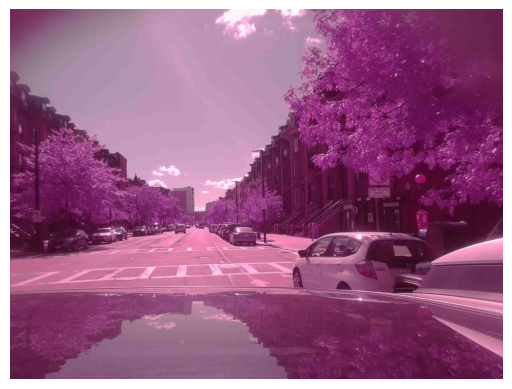

In [4]:
display_from_path(rgn_path)

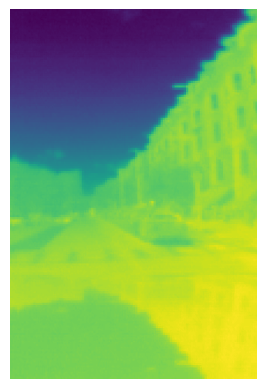

In [5]:
display_from_path(thermal_path)

## Image registration
Try `findTransformECC`
- Conclusion: This doesn't really work well because the sizes of images are so different.
- Source: https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/

In [76]:
im1 =  cv2.imread(rgn_path)
im2 =  cv2.imread(thermal_path)
 
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.bitwise_not(cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY))
# im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

cv2.imshow("Image 1", im1_gray)
cv2.imshow("Image 2", im2_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

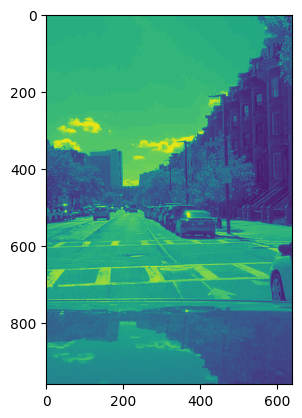

In [78]:
# Try to crop
w1, h1 = im1_gray.shape 
w2, h2 = im2_gray.shape 
cw, ch = w1//2 + 100, h1//2 - 120

im1_gray_cropped = im1_gray[cw-w2:cw+w2, ch-h2:ch+h2]

plt.imshow(im1_gray_cropped)

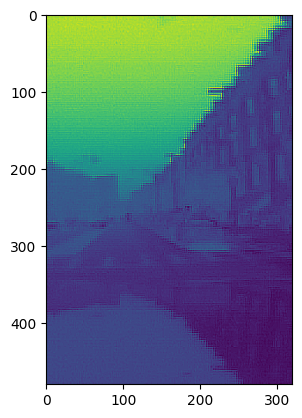

In [77]:
# Try sharpening thermal image
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
im = cv2.filter2D(im2_gray, -1, kernel)
plt.imshow(im)
# im2_gray = im

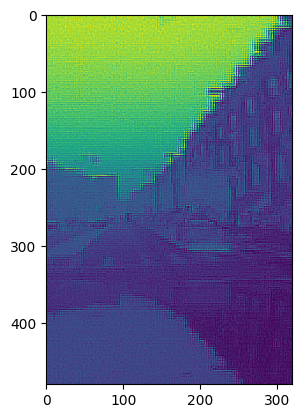

In [89]:
gaussian_3 = cv2.GaussianBlur(im2_gray, (0, 0), 2.0)
unsharp_image = cv2.addWeighted(im2_gray, 2.0, gaussian_3, -1.0, 0)
plt.imshow(unsharp_image)
# im2_gray = unsharp_image

In [97]:
cv2.imshow("Image 2", im2_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [92]:
# Find size of image1
sz = im1_gray_cropped.shape
sz

(960, 640)

In [93]:
# Define the motion model
# MOTION_TRANSLATION sets a translational motion model; warpMatrix is 2×3 with the first 2×2 part being the unity matrix and the rest two parameters being estimated.
# MOTION_EUCLIDEAN sets a Euclidean (rigid) transformation as motion model; three parameters are estimated; warpMatrix is 2×3.
# MOTION_AFFINE sets an affine motion model (DEFAULT); six parameters are estimated; warpMatrix is 2×3.
# MOTION_HOMOGRAPHY sets a homography as a motion model; eight parameters are estimated;`warpMatrix` is 3×3

warp_mode = cv2.MOTION_HOMOGRAPHY

In [94]:

 
# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
  warp_matrix = np.eye(3, 3, dtype=np.float32)
else :  
  warp_matrix = np.eye(2, 3, dtype=np.float32)
 
warp_matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [95]:
# Specify the number of iterations.
number_of_iterations = 5000
 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10
 
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 


In [96]:
# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray_cropped,im2_gray,warp_matrix, warp_mode, criteria)
 
if warp_mode == cv2.MOTION_HOMOGRAPHY :
# Use warpPerspective for Homography
  im2_aligned = cv2.warpPerspective (im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
# Use warpAffine for Translation, Euclidean and Affine
  im2_aligned = cv2.warpAffine(im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'


In [84]:
# Show final results
cv2.imshow("Image 1", im1_gray_cropped)
cv2.imshow("Image 2", im2_gray)
cv2.imshow("Aligned Image 2", im2_aligned)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Try SIFT for alignment
- Source: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
- Source: https://forum.image.sc/t/align-two-versions-of-the-same-image-that-are-at-different-resolutions-and-one-is-cropped/54737/5

In [8]:
im1 =  cv2.imread(rgn_path)
im2 =  cv2.imread(thermal_path)
 
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.bitwise_not(cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY))
# im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

cv2.imshow("Image 1", im1_gray)
cv2.imshow("Image 2", im2_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

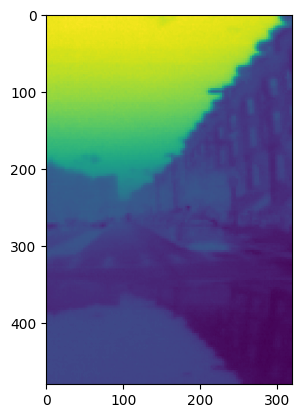

In [30]:
plt.imshow(im2_gray)

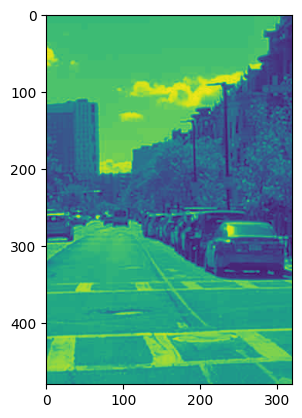

In [37]:
# Try to crop
w1, h1 = im1_gray.shape
w2, h2 = im2_gray.shape
cw, ch = w1//2 + 100, h1//2 - 150

im1_gray_cropped = im1_gray[cw-w2//2:cw+w2//2, ch-h2//2:ch+h2//2]

plt.imshow(im1_gray_cropped)

In [24]:
# Create mask for im1
# mask = np.zeros(im1_gray.shape[:2], dtype=np.uint8)

# # Specify the region of interest in the mask (centered)
# w1, h1 = im1_gray.shape
# w2, h2 = im2_gray.shape
# mask[w1//2-w2//2:w1//2+w2//2, h1//2-h2//2:h1//2+h2//2] = 255

In [38]:
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
# Here img1 and img2 are grayscale images
kp1, des1 = sift.detectAndCompute(im1_gray_cropped, None)
kp2, des2 = sift.detectAndCompute(im2_gray,None)

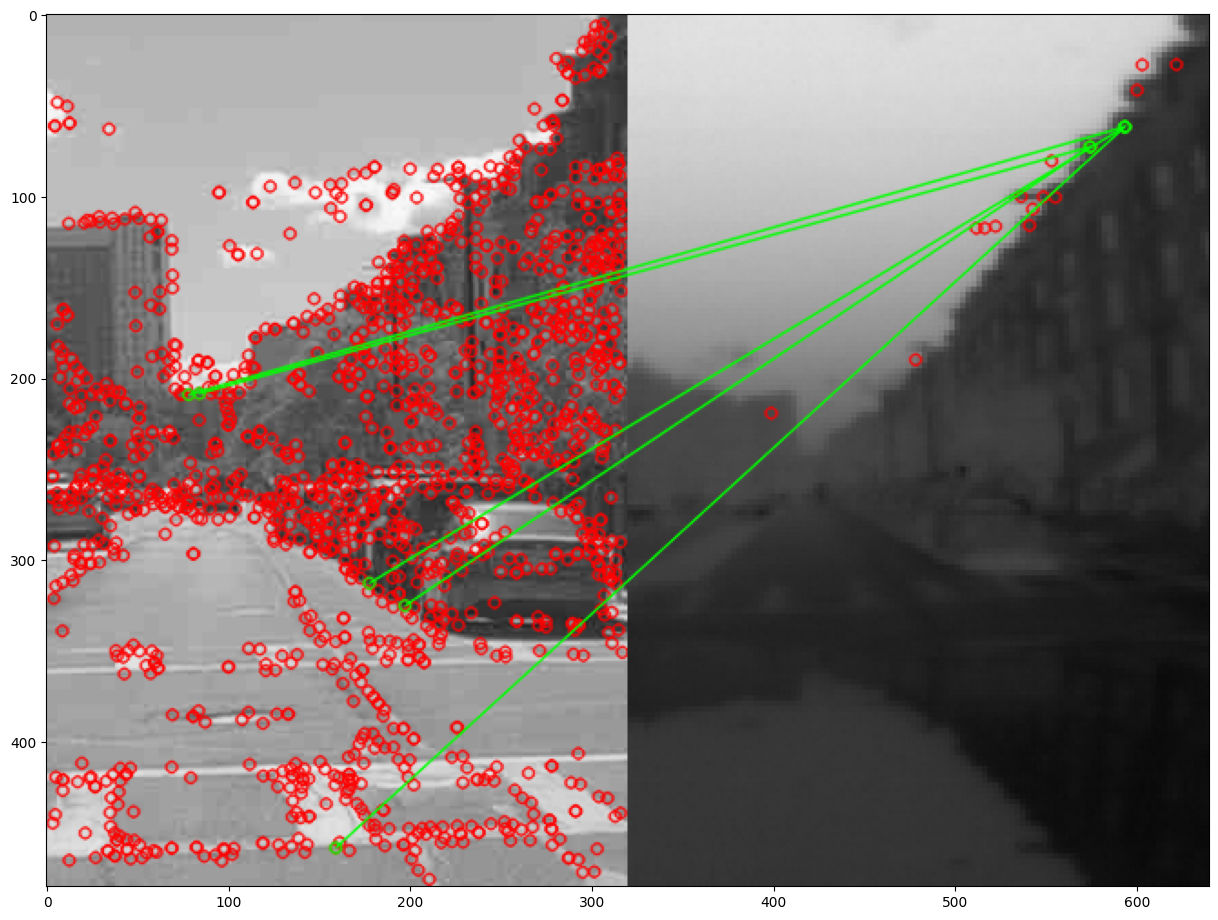

In [40]:
# FLANN parameters
# I literally copy-pasted the defaults
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
# do the matching
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

## OPTIONAL - Show matches ##

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for _ in range(len(matches))]
# ratio test as per Lowe's paper <- this is a criterion for matches selection
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(im1_gray_cropped,kp1,im2_gray,kp2,matches,None, **draw_params)
f, ax = plt.subplots(1, figsize=(15,15))
ax.imshow(img3)
plt.show()